**CONFIGURAÇÃO DO CLUSTER**

**1) Arquitetura.**

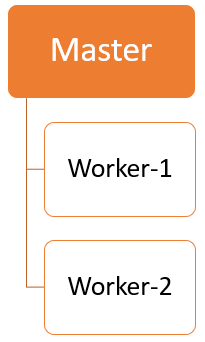

**2) Dockerfile**

In [ ]:
FROM ubuntu:18.04


USER root

RUN apt-get update && apt-get -y dist-upgrade && apt-get install -y openssh-server default-jdk wget scala
RUN  apt-get -y update
RUN  apt-get -y install zip 
RUN  apt-get -y install vim
ENV JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64

RUN ssh-keygen -t rsa -f $HOME/.ssh/id_rsa -P "" \
    && cat $HOME/.ssh/id_rsa.pub >> $HOME/.ssh/authorized_keys

RUN wget -O /hadoop.tar.gz -q http://archive.apache.org/dist/hadoop/core/hadoop-2.7.3/hadoop-2.7.3.tar.gz \
        && tar xfz hadoop.tar.gz \
        && mv /hadoop-2.7.3 /usr/local/hadoop \
        && rm /hadoop.tar.gz

RUN wget -O /spark.tar.gz -q https://archive.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
RUN tar xfz spark.tar.gz
RUN mv /spark-2.4.1-bin-hadoop2.7 /usr/local/spark
RUN rm /spark.tar.gz


ENV HADOOP_HOME=/usr/local/hadoop
ENV SPARK_HOME=/usr/local/spark
ENV PATH=$PATH:$HADOOP_HOME/bin:$HADOOP_HOME/sbin:$SPARK_HOME/bin:$SPARK_HOME:sbin

RUN mkdir -p $HADOOP_HOME/hdfs/namenode \
        && mkdir -p $HADOOP_HOME/hdfs/datanode


COPY config/ /tmp/
RUN mv /tmp/ssh_config $HOME/.ssh/config \
    && mv /tmp/hadoop-env.sh $HADOOP_HOME/etc/hadoop/hadoop-env.sh \
    && mv /tmp/core-site.xml $HADOOP_HOME/etc/hadoop/core-site.xml \
    && mv /tmp/hdfs-site.xml $HADOOP_HOME/etc/hadoop/hdfs-site.xml \
    && mv /tmp/mapred-site.xml $HADOOP_HOME/etc/hadoop/mapred-site.xml.template \
    && cp $HADOOP_HOME/etc/hadoop/mapred-site.xml.template $HADOOP_HOME/etc/hadoop/mapred-site.xml \
    && mv /tmp/yarn-site.xml $HADOOP_HOME/etc/hadoop/yarn-site.xml \
    && cp /tmp/slaves $HADOOP_HOME/etc/hadoop/slaves \
    && mv /tmp/slaves $SPARK_HOME/conf/slaves \
    && mv /tmp/spark/spark-env.sh $SPARK_HOME/conf/spark-env.sh \
    && mv /tmp/spark/log4j.properties $SPARK_HOME/conf/log4j.properties \
    && mv /tmp/spark/spark.defaults.conf $SPARK_HOME/conf/spark.defaults.conf

ADD scripts/spark-services.sh $HADOOP_HOME/spark-services.sh

RUN chmod 744 -R $HADOOP_HOME


RUN $HADOOP_HOME/bin/hdfs namenode -format

EXPOSE 50010 50020 50070 50075 50090 8020 9000
EXPOSE 10020 19888
EXPOSE 8030 8031 8032 8033 8040 8042 8088
EXPOSE 49707 2122 7001 7002 7003 7004 7005 7006 7007 8888 9000

ENTRYPOINT service ssh start; cd $SPARK_HOME; bash

**3) Cluster Hadoop**

In [ ]:
IMG_NAME="spark-hadoop-cluster"
HOST_PREFIX="cluster"
NETWORK_NAME=$HOST_PREFIX

N=${1:-2}
NET_QUERY=$(docker network ls | grep -i $NETWORK_NAME)
if [ -z "$NET_QUERY" ]; then
	docker network create --driver=bridge $NETWORK_NAME
fi

# START HADOOP SLAVES 
i=1
while [ $i -le $N ]
do
	HADOOP_SLAVE="$HOST_PREFIX"-slave-$i
	docker run --name $HADOOP_SLAVE -h $HADOOP_SLAVE --net=$NETWORK_NAME -itd "$IMG_NAME"
	i=$(( $i + 1 ))
done

# START HADOOP MASTER

HADOOP_MASTER="$HOST_PREFIX"-master
docker run --name $HADOOP_MASTER -h $HADOOP_MASTER --net=$NETWORK_NAME \
		-p  8088:8088  -p 50070:50070 -p 50090:50090 \
		-p  8080:8080 \
		-itd "$IMG_NAME"


# START MULTI-NODES CLUSTER
docker exec -it $HADOOP_MASTER "/usr/local/hadoop/spark-services.sh"

**2.1) Hadoop-env**

In [ ]:
# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements.  See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership.  The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License.  You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Set Hadoop-specific environment variables here.

# The only required environment variable is JAVA_HOME.  All others are
# optional.  When running a distributed configuration it is best to
# set JAVA_HOME in this file, so that it is correctly defined on
# remote nodes.

# The java implementation to use.
export JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64

# The jsvc implementation to use. Jsvc is required to run secure datanodes
# that bind to privileged ports to provide authentication of data transfer
# protocol.  Jsvc is not required if SASL is configured for authentication of
# data transfer protocol using non-privileged ports.
#export JSVC_HOME=${JSVC_HOME}

export HADOOP_CONF_DIR=${HADOOP_CONF_DIR:-"/etc/hadoop"}

# Extra Java CLASSPATH elements.  Automatically insert capacity-scheduler.
for f in $HADOOP_HOME/contrib/capacity-scheduler/*.jar; do
  if [ "$HADOOP_CLASSPATH" ]; then
    export HADOOP_CLASSPATH=$HADOOP_CLASSPATH:$f
  else
    export HADOOP_CLASSPATH=$f
  fi
done

# The maximum amount of heap to use, in MB. Default is 1000.
#export HADOOP_HEAPSIZE=
#export HADOOP_NAMENODE_INIT_HEAPSIZE=""

# Extra Java runtime options.  Empty by default.
# disable ipv6 - https://wiki.apache.org/hadoop/HadoopIPv6
export HADOOP_OPTS="$HADOOP_OPTS -Djava.net.preferIPv4Stack=true"

# Command specific options appended to HADOOP_OPTS when specified
export HADOOP_NAMENODE_OPTS="-Dhadoop.security.logger=${HADOOP_SECURITY_LOGGER:-INFO,RFAS} -Dhdfs.audit.logger=${HDFS_AUDIT_LOGGER:-INFO,NullAppender} $HADOOP_NAMENODE_OPTS"
export HADOOP_DATANODE_OPTS="-Dhadoop.security.logger=ERROR,RFAS $HADOOP_DATANODE_OPTS"

export HADOOP_SECONDARYNAMENODE_OPTS="-Dhadoop.security.logger=${HADOOP_SECURITY_LOGGER:-INFO,RFAS} -Dhdfs.audit.logger=${HDFS_AUDIT_LOGGER:-INFO,NullAppender} $HADOOP_SECONDARYNAMENODE_OPTS"

export HADOOP_NFS3_OPTS="$HADOOP_NFS3_OPTS"
export HADOOP_PORTMAP_OPTS="-Xmx512m $HADOOP_PORTMAP_OPTS"

# The following applies to multiple commands (fs, dfs, fsck, distcp etc)
export HADOOP_CLIENT_OPTS="-Xmx512m $HADOOP_CLIENT_OPTS"
#HADOOP_JAVA_PLATFORM_OPTS="-XX:-UsePerfData $HADOOP_JAVA_PLATFORM_OPTS"

# On secure datanodes, user to run the datanode as after dropping privileges.
# This **MUST** be uncommented to enable secure HDFS if using privileged ports
# to provide authentication of data transfer protocol.  This **MUST NOT** be
# defined if SASL is configured for authentication of data transfer protocol
# using non-privileged ports.
export HADOOP_SECURE_DN_USER=${HADOOP_SECURE_DN_USER}

# Where log files are stored.  $HADOOP_HOME/logs by default.
#export HADOOP_LOG_DIR=${HADOOP_LOG_DIR}/$USER

# Where log files are stored in the secure data environment.
export HADOOP_SECURE_DN_LOG_DIR=${HADOOP_LOG_DIR}/${HADOOP_HDFS_USER}

###
# HDFS Mover specific parameters
###
# Specify the JVM options to be used when starting the HDFS Mover.
# These options will be appended to the options specified as HADOOP_OPTS
# and therefore may override any similar flags set in HADOOP_OPTS
#
# export HADOOP_MOVER_OPTS=""

###
# Advanced Users Only!
###

# The directory where pid files are stored. /tmp by default.
# NOTE: this should be set to a directory that can only be written to by 
#       the user that will run the hadoop daemons.  Otherwise there is the
#       potential for a symlink attack.
export HADOOP_PID_DIR=${HADOOP_PID_DIR}
export HADOOP_SECURE_DN_PID_DIR=${HADOOP_PID_DIR}

# A string representing this instance of hadoop. $USER by default.
export HADOOP_IDENT_STRING=$USER

# FIX PROBLEM: ssh: The authenticity of host 'hostname' can't be established
export HADOOP_SSH_OPTS="-o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"

**3.2) slaves**

In [ ]:
cluster-slave-1
cluster-slave-2

**3.3) core-site.xml**

In [ ]:
<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<configuration>
	<!--
	  Pseudo-Distributed Mode.
	-->
	<property>
	   <name>fs.defaultFS</name>
	   <value>hdfs://cluster-master:9000/</value>
	</property>
	<property>
	   <name>io.file.buffer.size</name>
	   <value>131072</value>
	</property>
</configuration>

**3.4) hdfs-site.xml**

In [ ]:
<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<configuration>
	<!--
	  Pseudo-Distributed Mode.
	-->
	<property>
		<name>dfs.blocksize</name>
		<value>134217728</value>
	</property>
	<property>
		<name>dfs.replication</name>
		<value>1</value>
	</property>
	<property>
		<name>dfs.namenode.name.dir</name>
		<value>file:///usr/local/hadoop/hdfs/namenode</value>
	</property>
	<property>
		<name>dfs.datanode.data.dir</name>
		<value>file:///usr/local/hadoop/hdfs/datanode</value>
	</property>
</configuration>

**3.5) mapred-site.xml**

In [ ]:
<?xml version="1.0"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<configuration>
	<!--
	  Pseudo-Distributed Mode + YARN Setup.
	-->
    <property>
       <name>mapreduce.framework.name</name>
       <value>yarn</value>
    </property>
</configuration>

**3.6) yarn-site.xml**

In [ ]:
<?xml version="1.0"?>
<configuration>
	<!--
	  Pseudo-Distributed Mode + YARN Setup.
	-->
    <property>
       <name>yarn.nodemanager.aux-services</name>
       <value>mapreduce_shuffle</value>
    </property>
    <property>
       <name>yarn.nodemanager.aux-services.mapreduce.shuffle.class</name>
       <value>org.apache.hadoop.mapred.ShuffleHandler</value>
    </property>
	<!--
	  Fully-Distributed Mode + YARN Setup.
	-->
    <property>
        <name>yarn.resourcemanager.hostname</name>
        <value>cluster-master</value>
    </property>

<property>
    <name>yarn.resourcemanager.scheduler.address</name>
    <value>cluster-master:8030</value>
  </property>
  <property>
    <name>yarn.resourcemanager.address</name>
    <value>cluster-master:8032</value>
  </property>
  <property>
    <name>yarn.resourcemanager.webapp.address</name>
    <value>cluster-master:8088</value>
  </property>
  <property>
    <name>yarn.resourcemanager.resource-tracker.address</name>
    <value>cluster-master:8031</value>
  </property>
  <property>
    <name>yarn.resourcemanager.admin.address</name>
    <value>cluster-master:8033</value>
  </property>
<property>
   <name>yarn.nodemanager.disk-health-checker.enable</name>
   <value>false</value>
</property>
<property>
    <name>yarn.nodemanager.pmem-check-enabled</name>
    <value>false</value>
</property>

<property>
    <name>yarn.nodemanager.vmem-check-enabled</name>
    <value>false</value>
</property>


</configuration>

**4) Spark**

**4.1) log4j.properties**

In [ ]:
#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Set everything to be logged to the console
log4j.rootCategory=INFO, console
log4j.appender.console=org.apache.log4j.ConsoleAppender
log4j.appender.console.target=System.err
log4j.appender.console.layout=org.apache.log4j.PatternLayout
log4j.appender.console.layout.ConversionPattern=%d{yy/MM/dd HH:mm:ss} %p %c{1}: %m%n

# Set the default spark-shell log level to WARN. When running the spark-shell, the
# log level for this class is used to overwrite the root logger's log level, so that
# the user can have different defaults for the shell and regular Spark apps.
log4j.logger.org.apache.spark.repl.Main=INFO

# Settings to quiet third party logs that are too verbose
log4j.logger.org.spark_project.jetty=WARN
log4j.logger.org.spark_project.jetty.util.component.AbstractLifeCycle=ERROR
log4j.logger.org.apache.spark.repl.SparkIMain$exprTyper=WARN
log4j.logger.org.apache.spark.repl.SparkILoop$SparkILoopInterpreter=WARN
log4j.logger.org.apache.parquet=ERROR
log4j.logger.parquet=ERROR

# SPARK-9183: Settings to avoid annoying messages when looking up nonexistent UDFs in SparkSQL with Hive support
log4j.logger.org.apache.hadoop.hive.metastore.RetryingHMSHandler=FATAL
log4j.logger.org.apache.hadoop.hive.ql.exec.FunctionRegistry=ERROR


**4.2) spark-defaults-conf**

In [ ]:
spark.yarn.archive hdfs:///apps/spark/spark-jars.zip

**4.3) spark-env.sh**

In [ ]:
#!/usr/bin/env bash

#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# This file is sourced when running various Spark programs.
# Copy it as spark-env.sh and edit that to configure Spark for your site.

# Options read when launching programs locally with
# ./bin/run-example or ./bin/spark-submit
# - HADOOP_CONF_DIR, to point Spark towards Hadoop configuration files
# - SPARK_LOCAL_IP, to set the IP address Spark binds to on this node
# - SPARK_PUBLIC_DNS, to set the public dns name of the driver program

# Options read by executors and drivers running inside the cluster
# - SPARK_LOCAL_IP, to set the IP address Spark binds to on this node
# - SPARK_PUBLIC_DNS, to set the public DNS name of the driver program
# - SPARK_LOCAL_DIRS, storage directories to use on this node for shuffle and RDD data
# - MESOS_NATIVE_JAVA_LIBRARY, to point to your libmesos.so if you use Mesos

# Options read in YARN client mode
# - HADOOP_CONF_DIR, to point Spark towards Hadoop configuration files
export HADOOP_CONF_DIR=$HADOOP_HOME/etc/hadoop
# - YARN_CONF_DIR, to point Spark towards YARN configuration files when you use YARN
export YARN_CONF_DIR=$HADOOP_CONF_DIR
# - SPARK_EXECUTOR_CORES, Number of cores for the executors (Default: 1).
# - SPARK_EXECUTOR_MEMORY, Memory per Executor (e.g. 1000M, 2G) (Default: 1G)
# - SPARK_DRIVER_MEMORY, Memory for Driver (e.g. 1000M, 2G) (Default: 1G)

# Options for the daemons used in the standalone deploy mode
# - SPARK_MASTER_HOST, to bind the master to a different IP address or hostname
# - SPARK_MASTER_PORT / SPARK_MASTER_WEBUI_PORT, to use non-default ports for the master
# - SPARK_MASTER_OPTS, to set config properties only for the master (e.g. "-Dx=y")
# - SPARK_WORKER_CORES, to set the number of cores to use on this machine
export SPARK_WORKER_CORES=2
# - SPARK_WORKER_MEMORY, to set how much total memory workers have to give executors (e.g. 1000m, 2g)
export SPARK_WORKER_MEMORY=2048m
# - SPARK_WORKER_PORT / SPARK_WORKER_WEBUI_PORT, to use non-default ports for the worker
# - SPARK_WORKER_DIR, to set the working directory of worker processes
# - SPARK_WORKER_OPTS, to set config properties only for the worker (e.g. "-Dx=y")
# - SPARK_DAEMON_MEMORY, to allocate to the master, worker and history server themselves (default: 1g).
# - SPARK_HISTORY_OPTS, to set config properties only for the history server (e.g. "-Dx=y")
# - SPARK_SHUFFLE_OPTS, to set config properties only for the external shuffle service (e.g. "-Dx=y")
# - SPARK_DAEMON_JAVA_OPTS, to set config properties for all daemons (e.g. "-Dx=y")
# - SPARK_DAEMON_CLASSPATH, to set the classpath for all daemons
# - SPARK_PUBLIC_DNS, to set the public dns name of the master or workers

# Generic options for the daemons used in the standalone deploy mode
# - SPARK_CONF_DIR      Alternate conf dir. (Default: ${SPARK_HOME}/conf)
# - SPARK_LOG_DIR       Where log files are stored.  (Default: ${SPARK_HOME}/logs)
# - SPARK_PID_DIR       Where the pid file is stored. (Default: /tmp)
# - SPARK_IDENT_STRING  A string representing this instance of spark. (Default: $USER)
# - SPARK_NICENESS      The scheduling priority for daemons. (Default: 0)
# - SPARK_NO_DAEMONIZE  Run the proposed command in the foreground. It will not output a PID file.
# Options for native BLAS, like Intel MKL, OpenBLAS, and so on.
# You might get better performance to enable these options if using native BLAS (see SPARK-21305).
# - MKL_NUM_THREADS=1        Disable multi-threading of Intel MKL
# - OPENBLAS_NUM_THREADS=1   Disable multi-threading of OpenBLAS

**INICIANDO O CLUSTER**

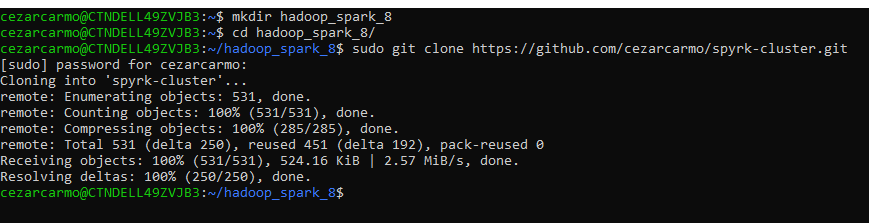

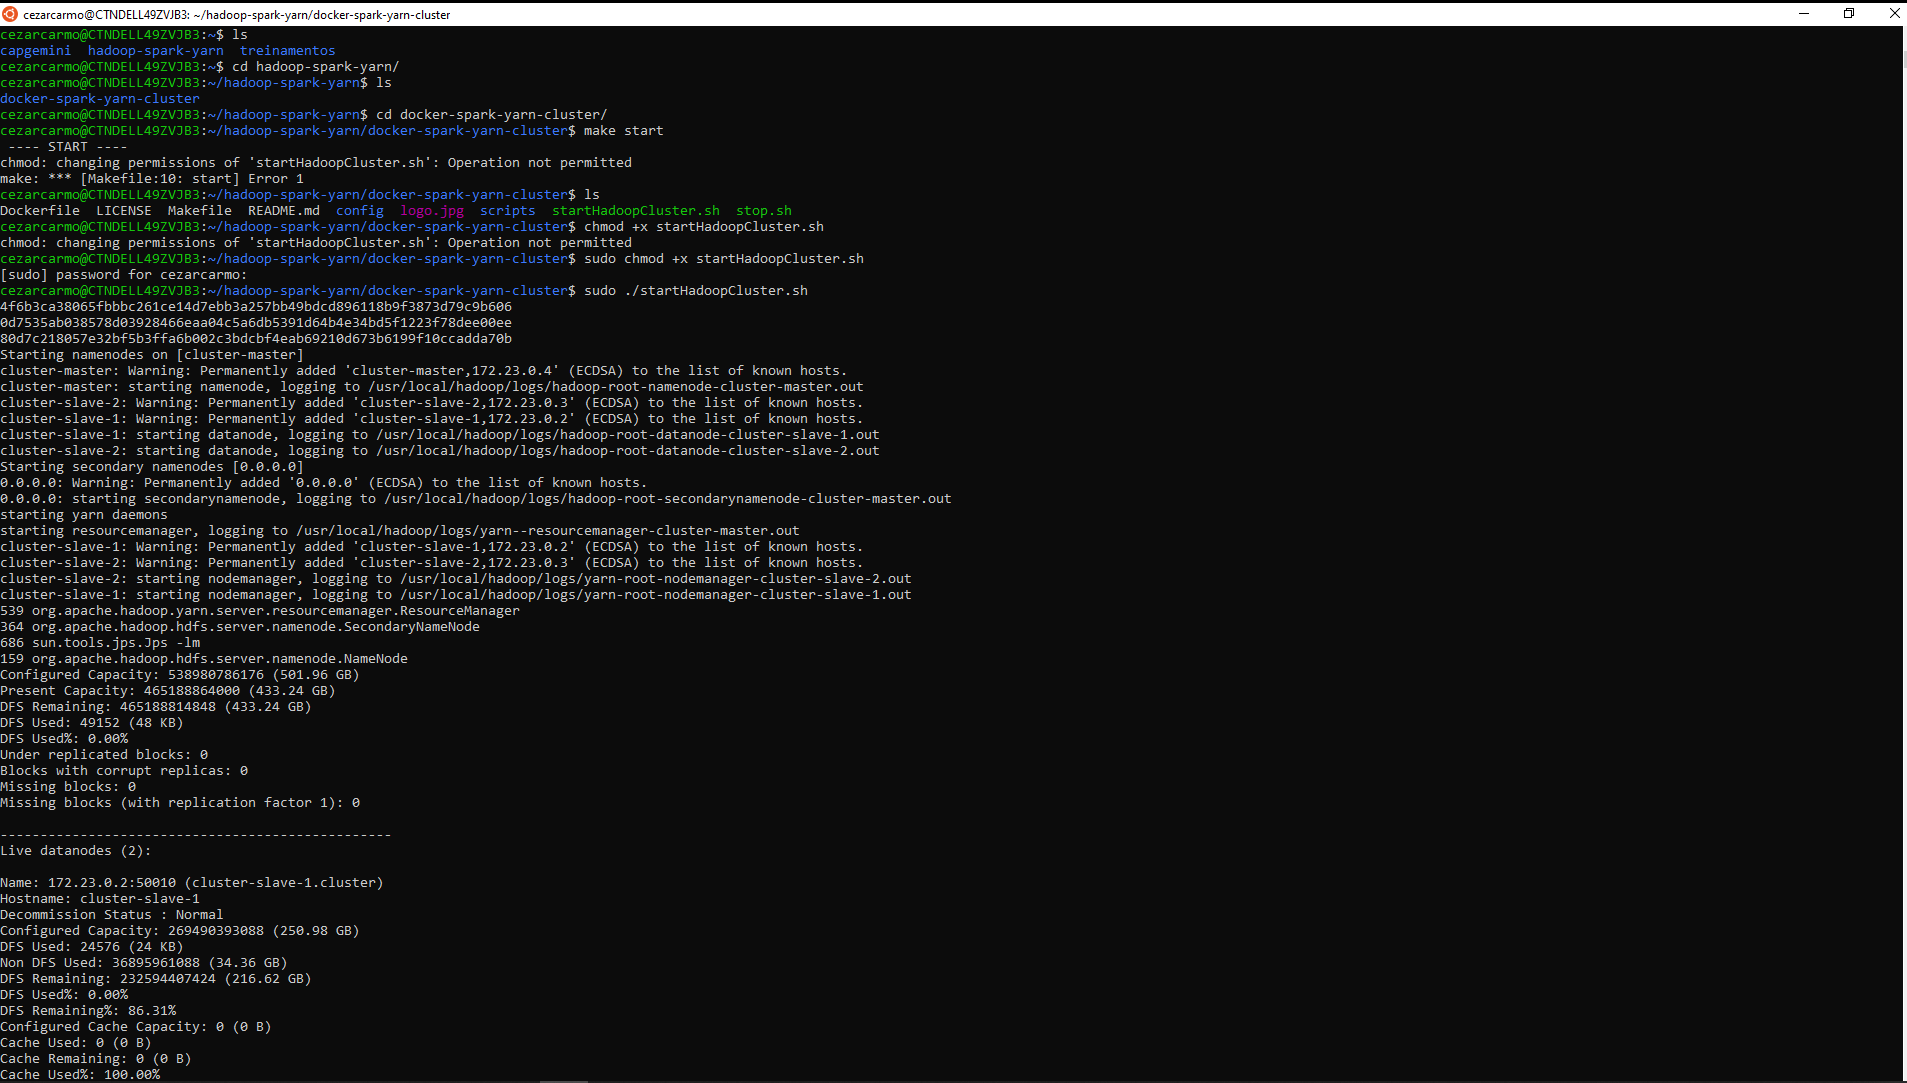

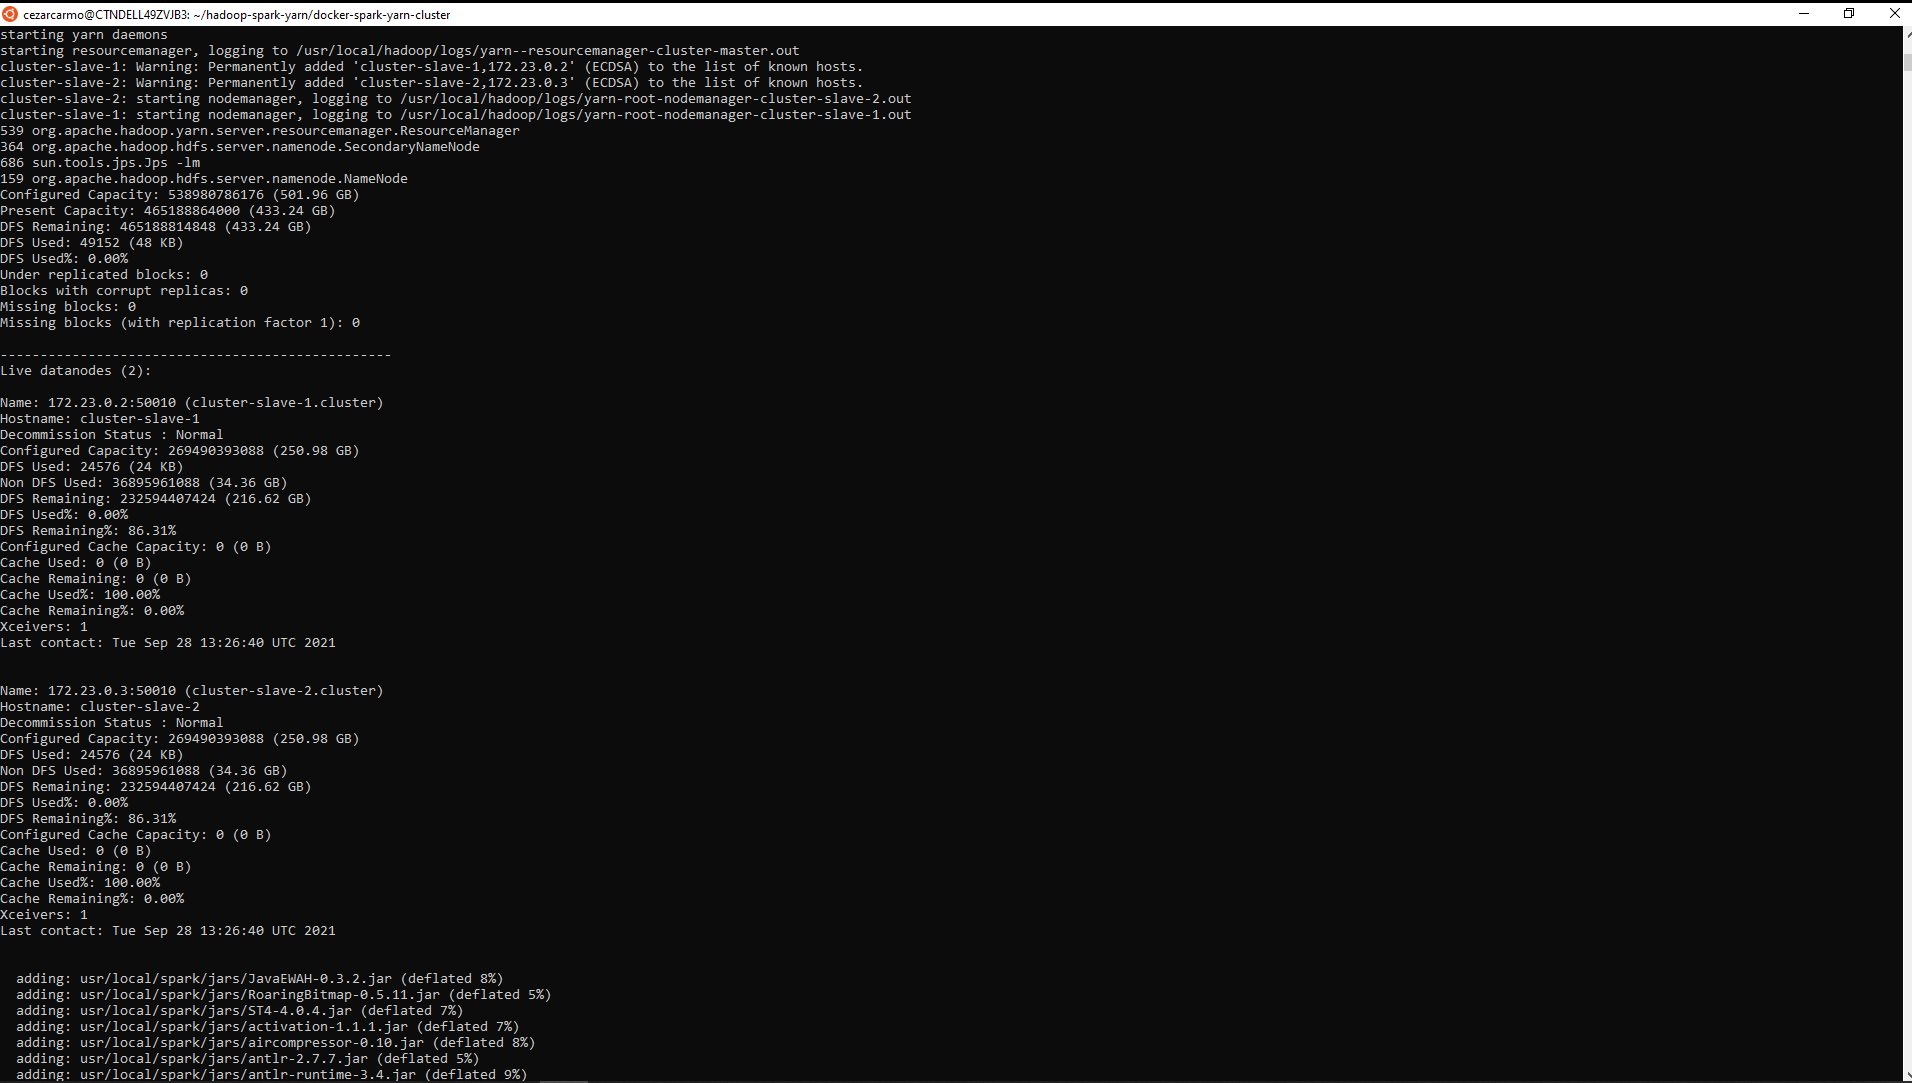

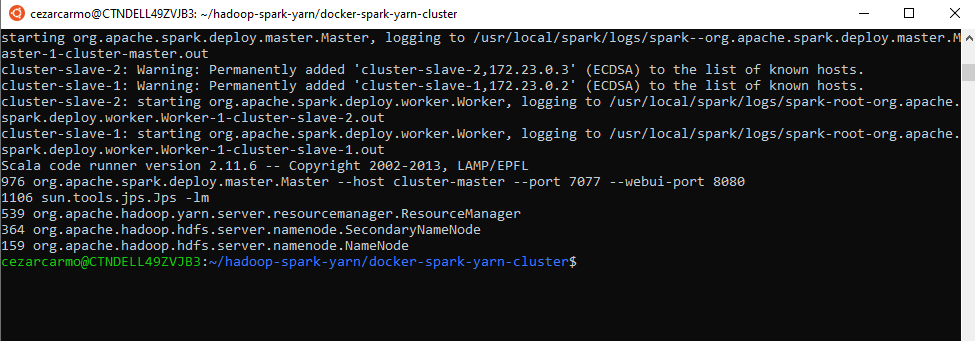

**CONEXAO MASTER-NODE - SPARK**

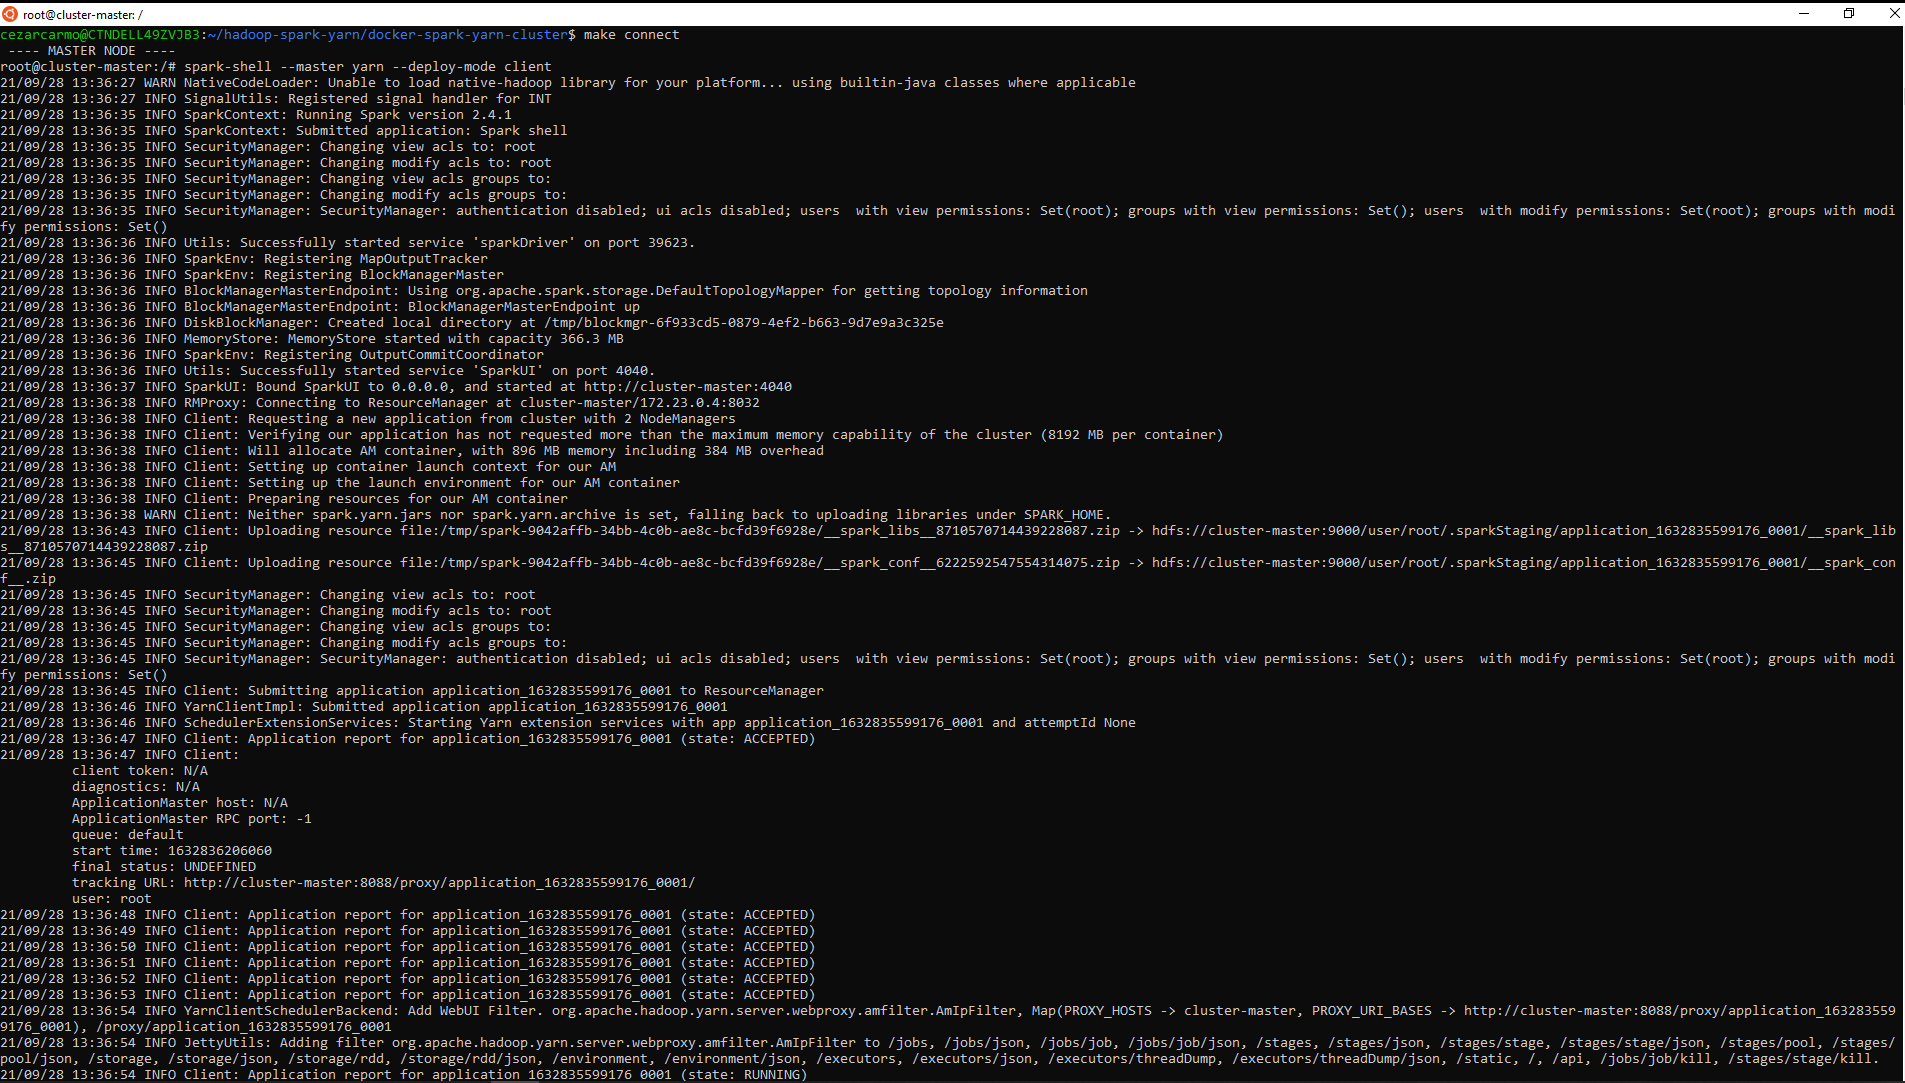

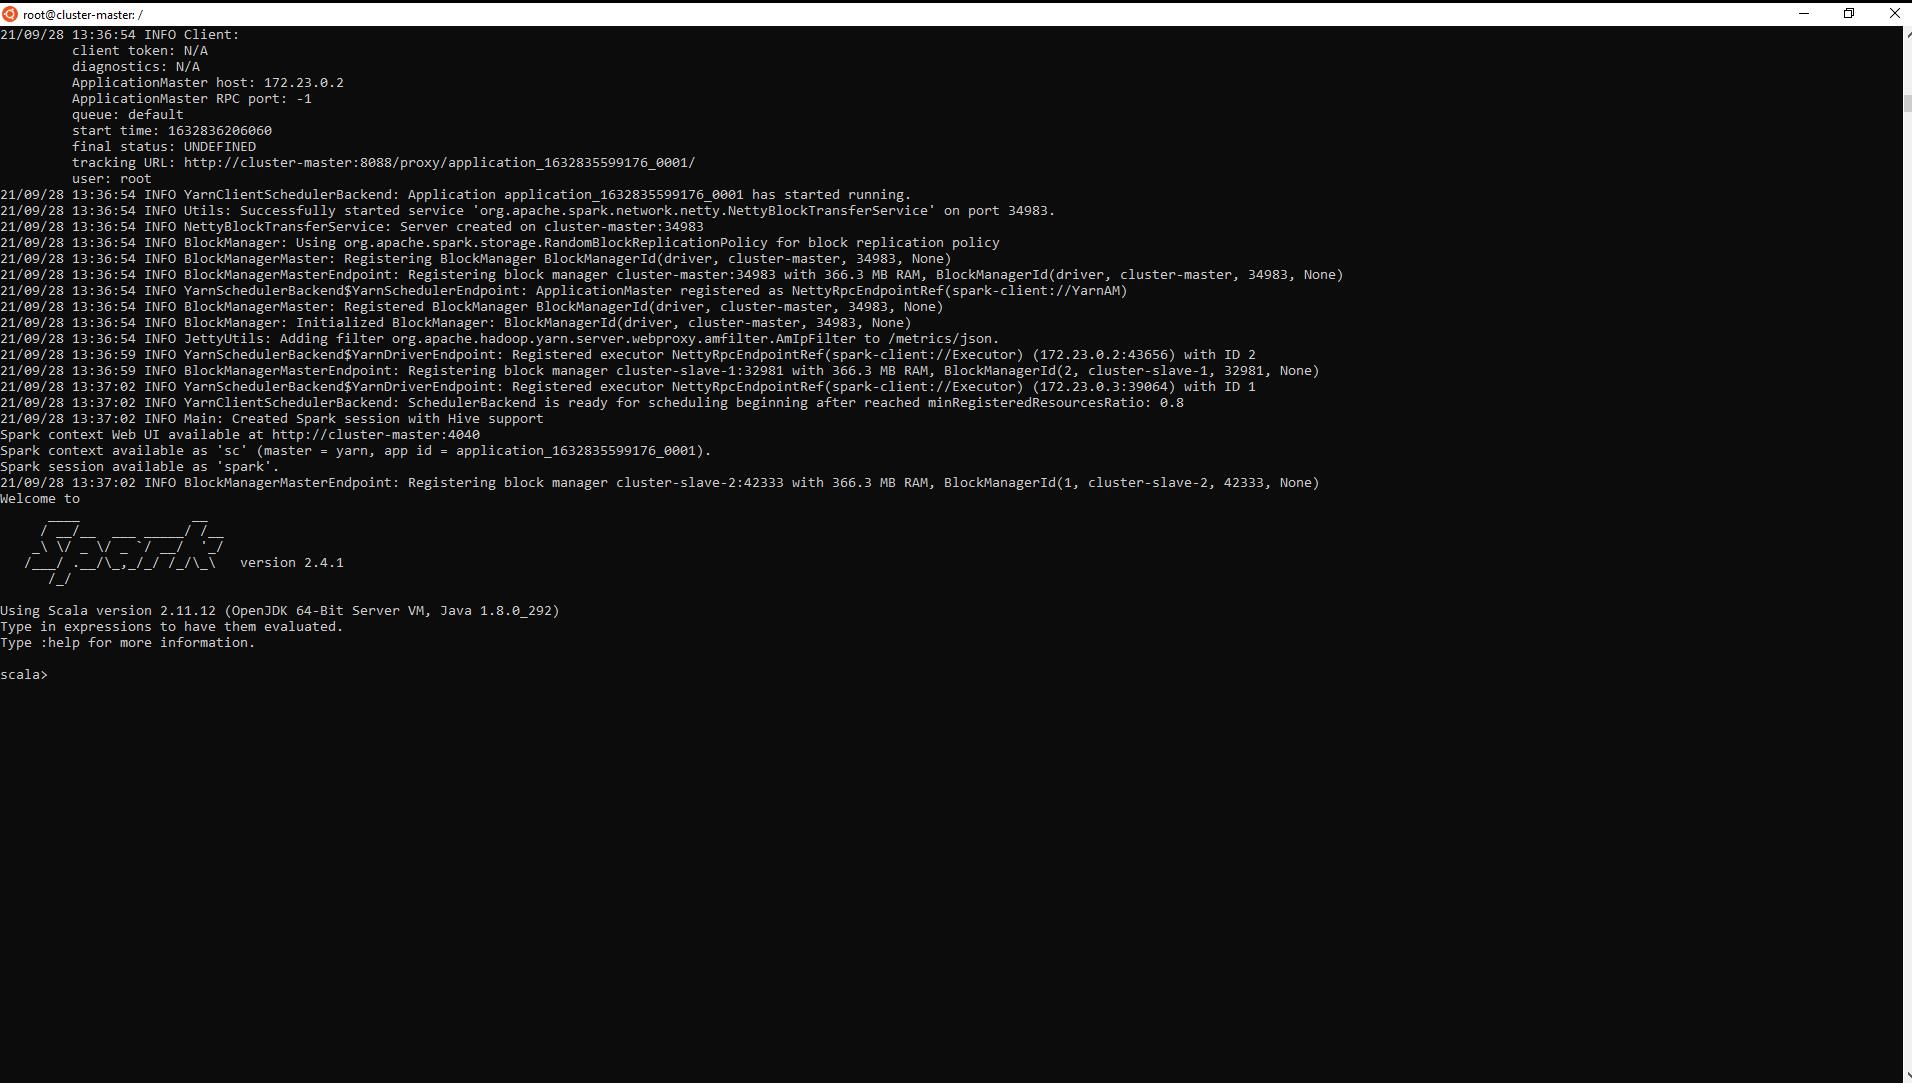

**SPARK-SUBMIT**

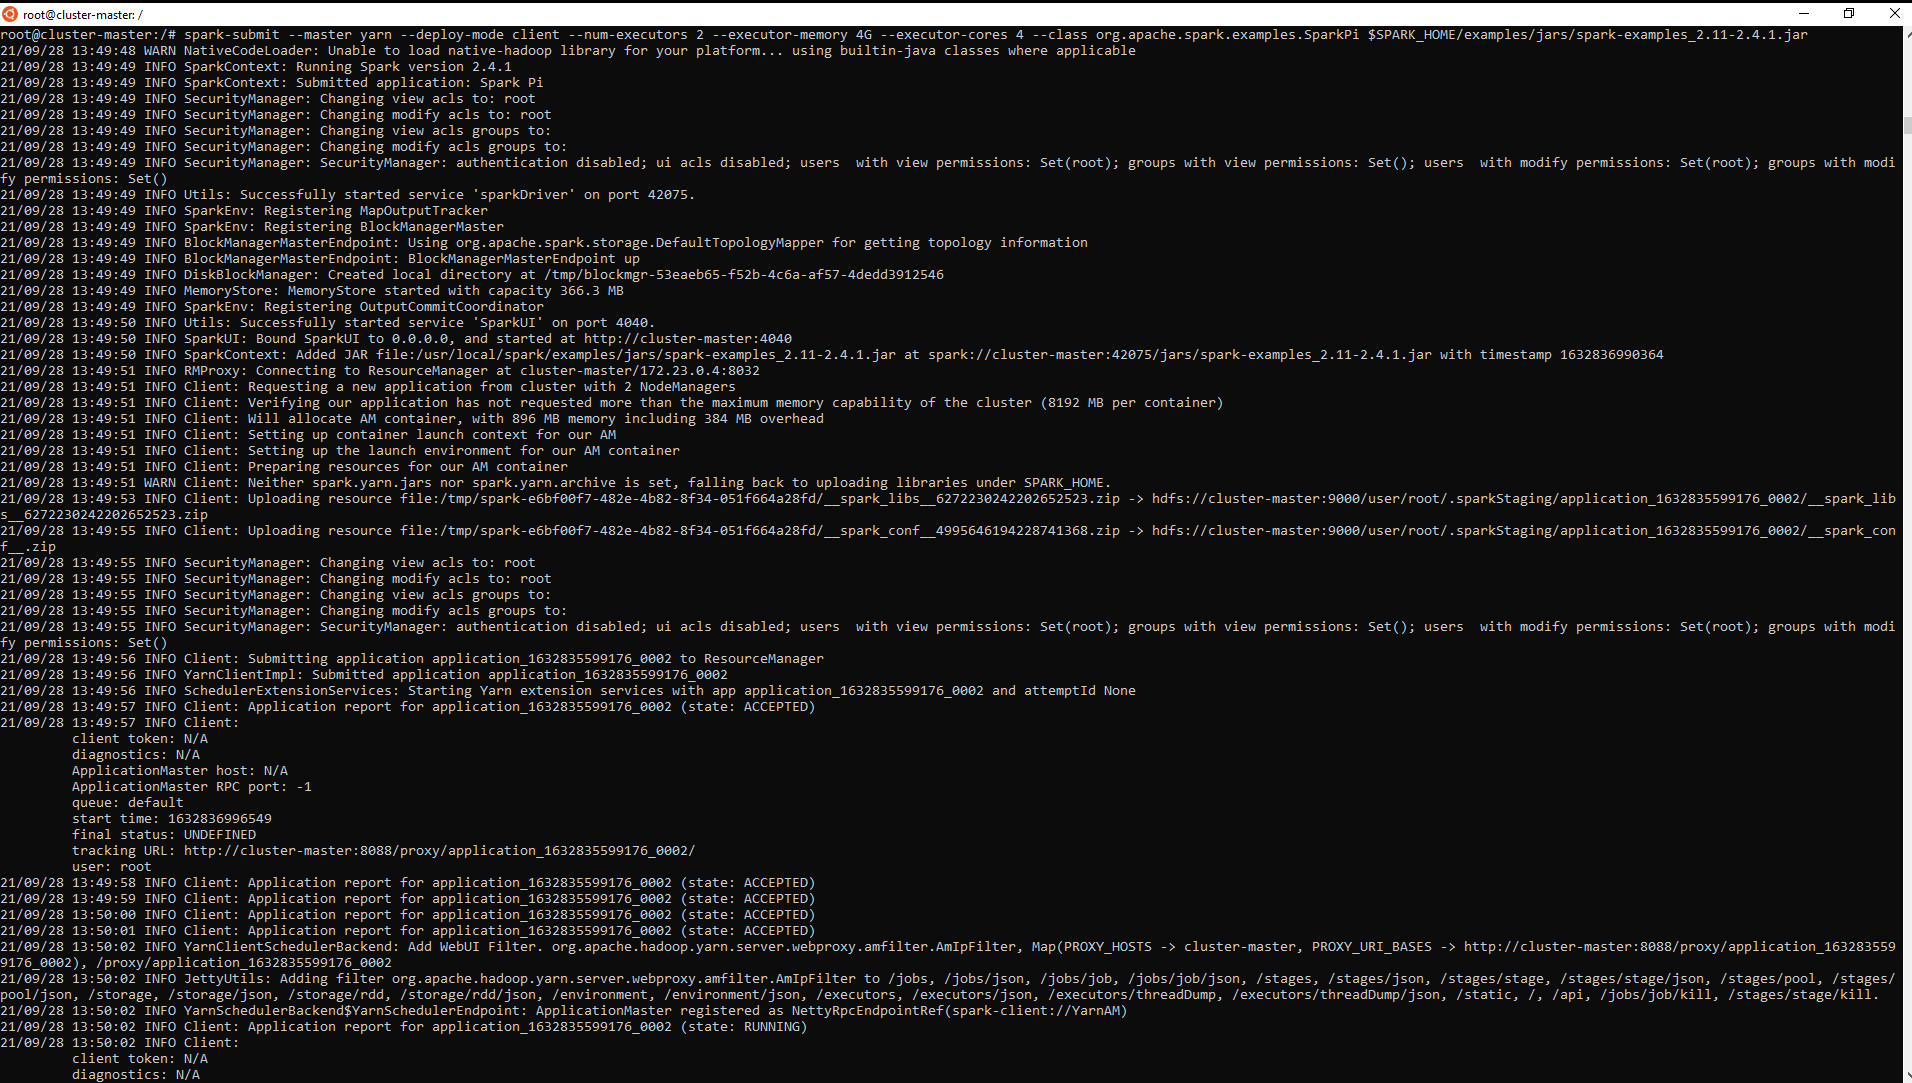

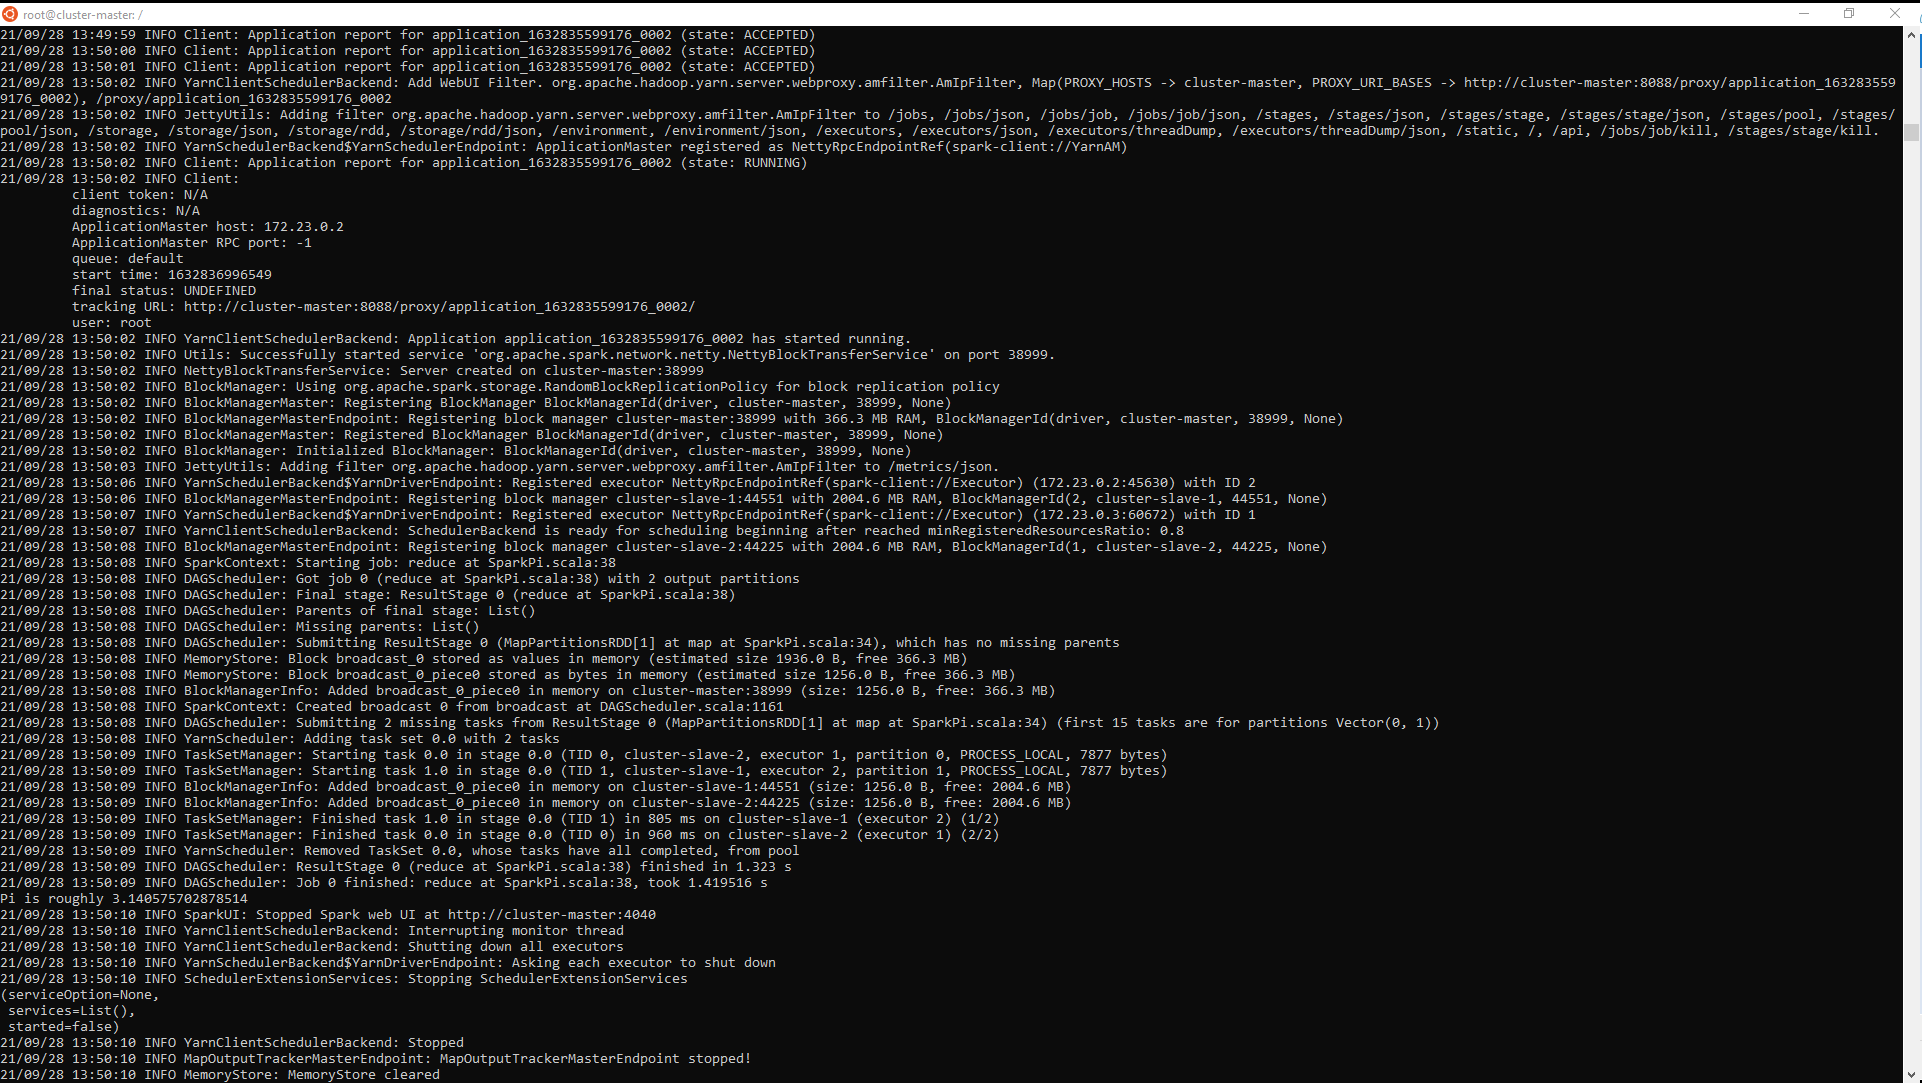

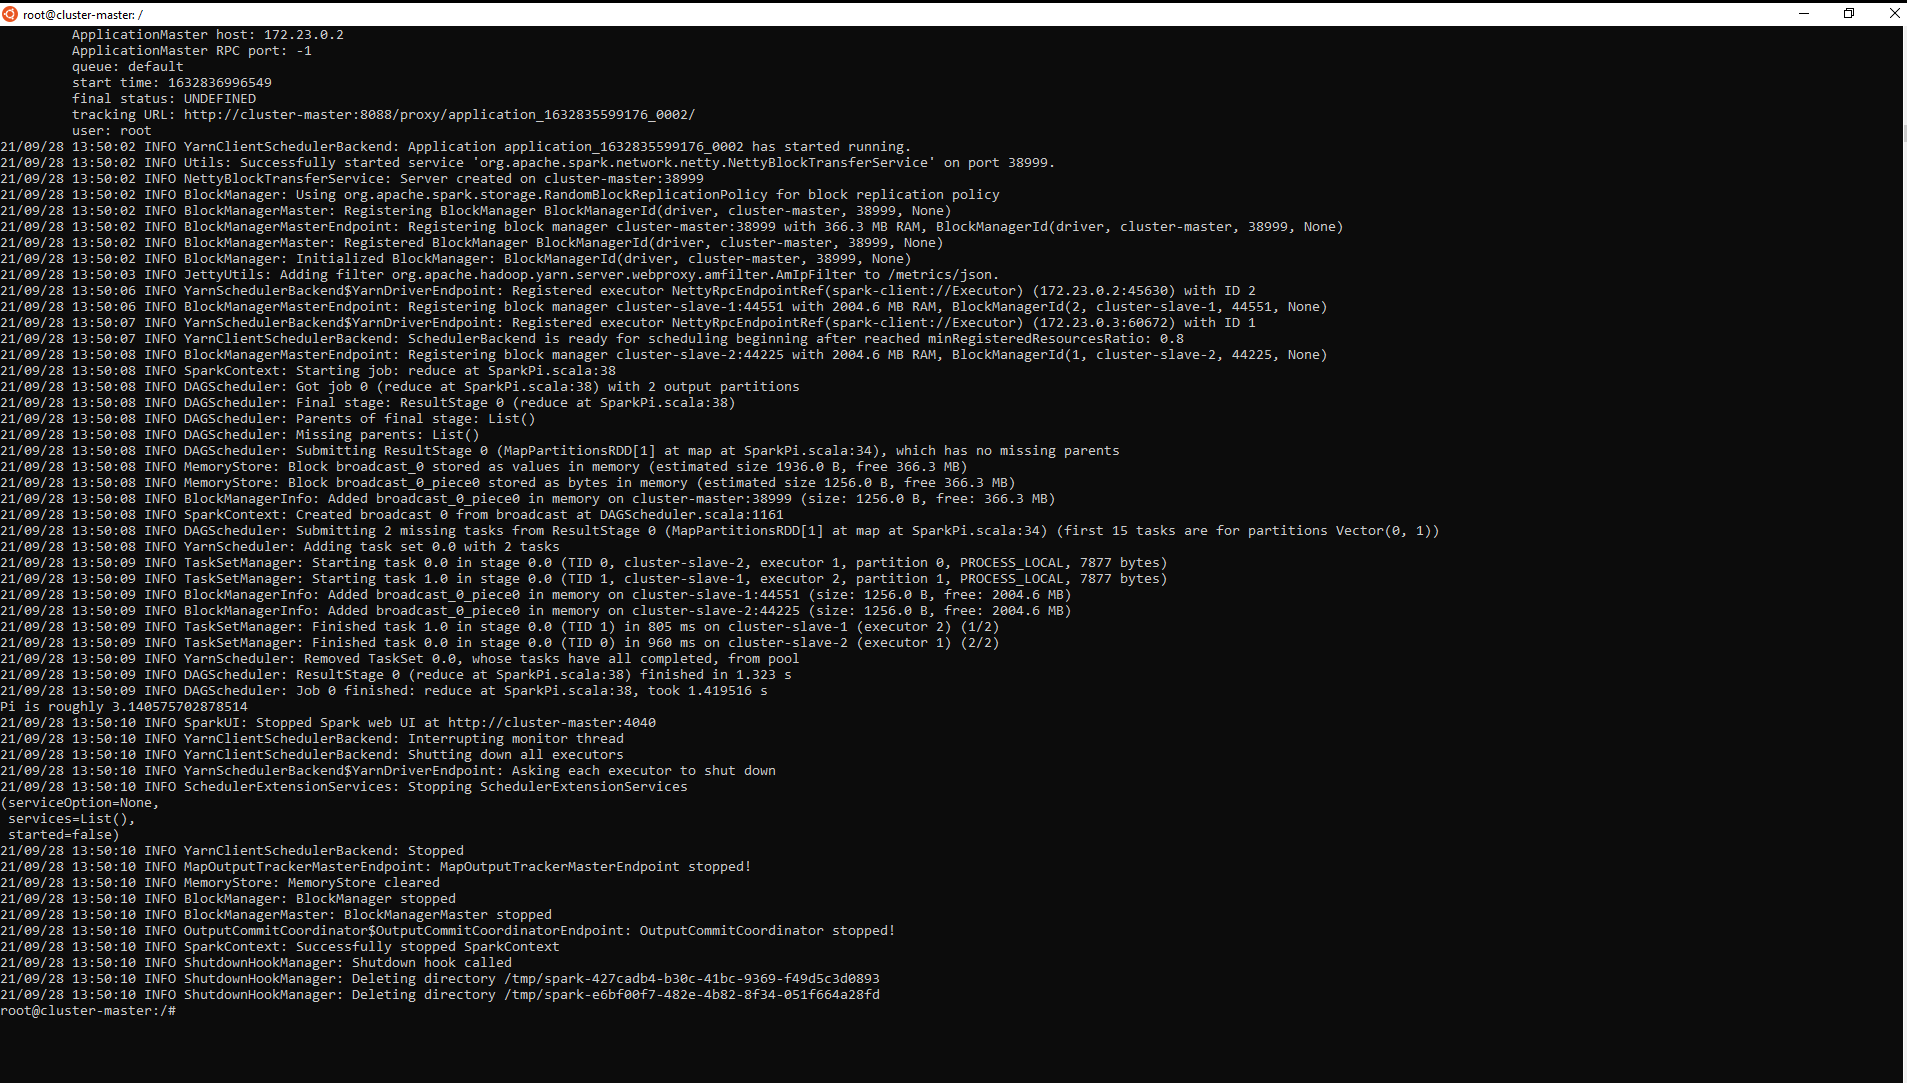

**Hadoop cluster Web UI : master-node-ip:8088**

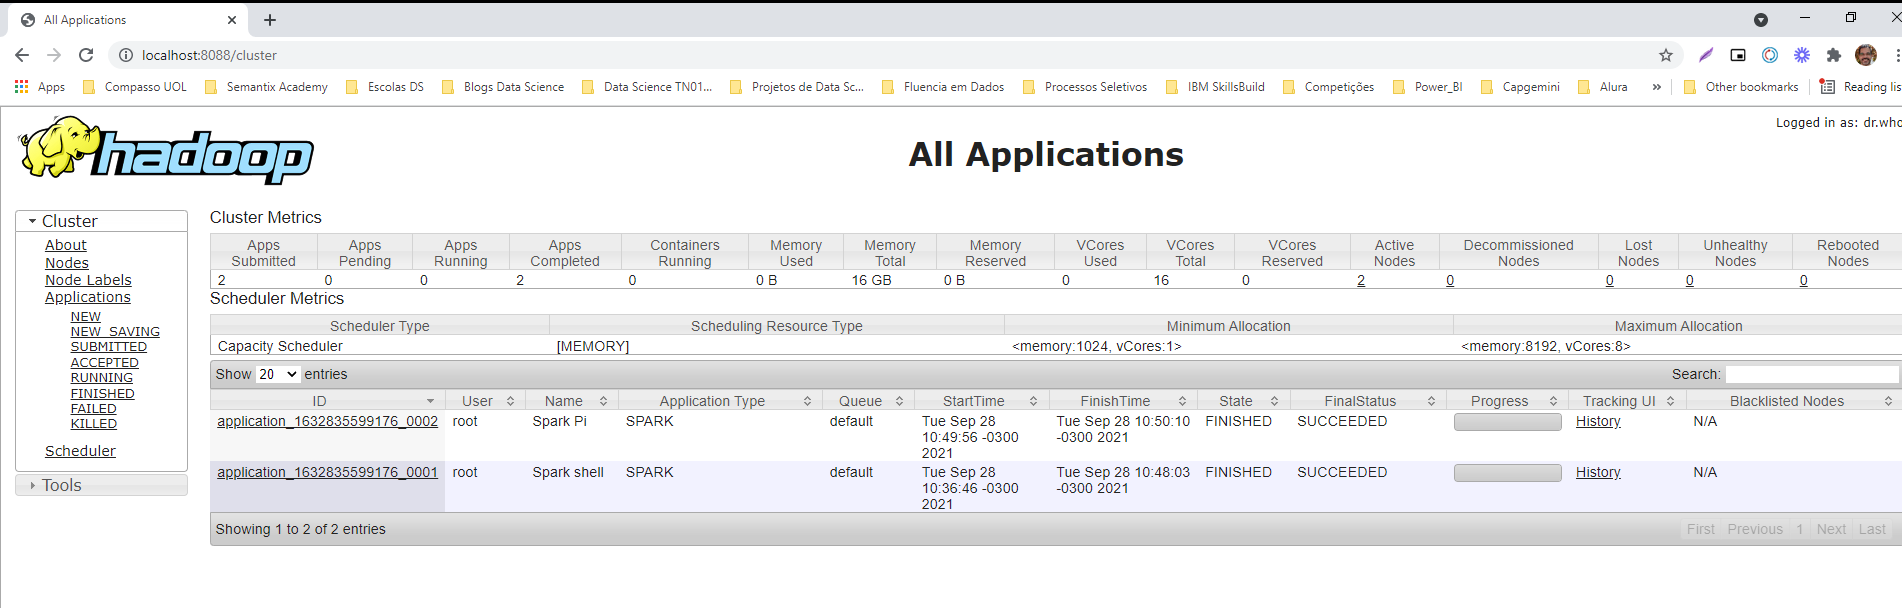

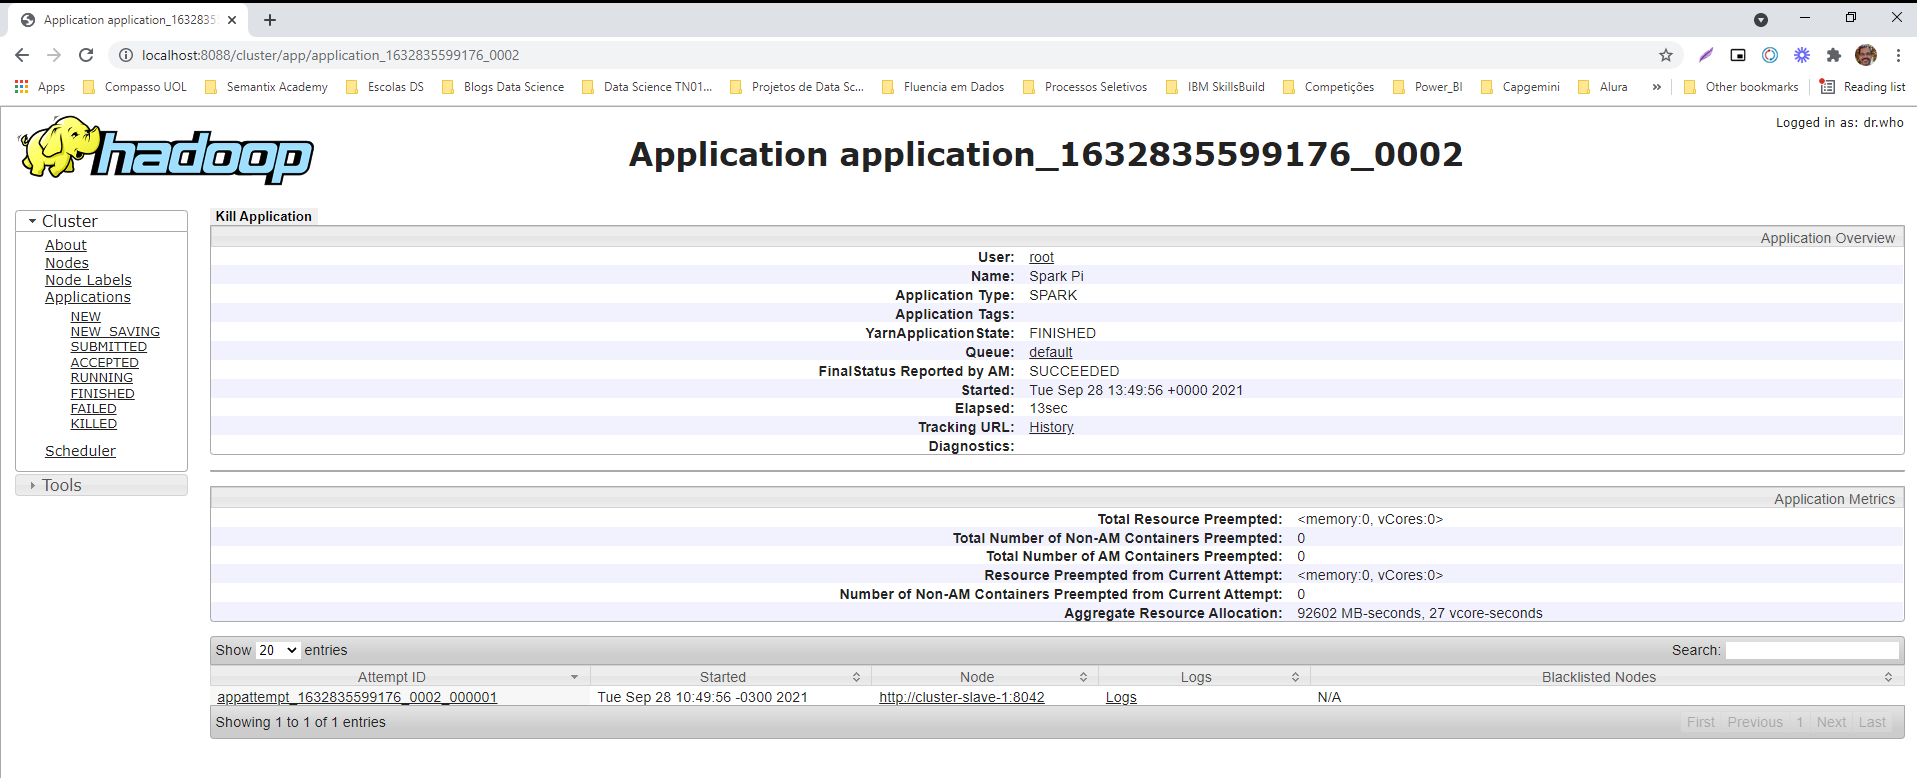

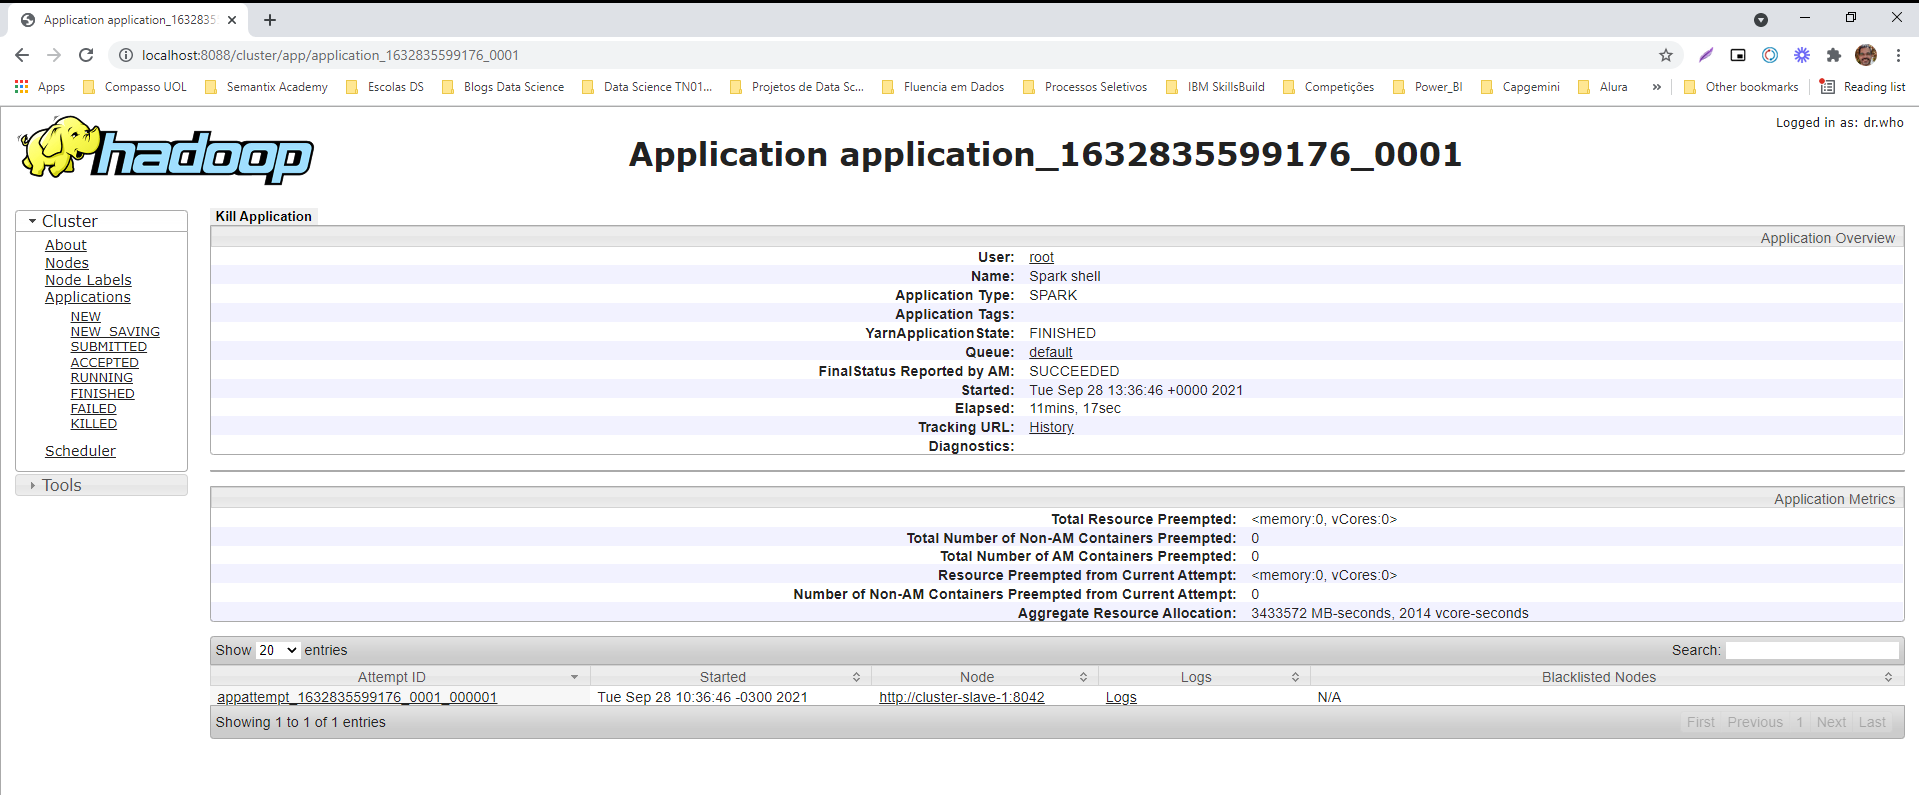

**Spark Web UI : master-node-ip:8080**

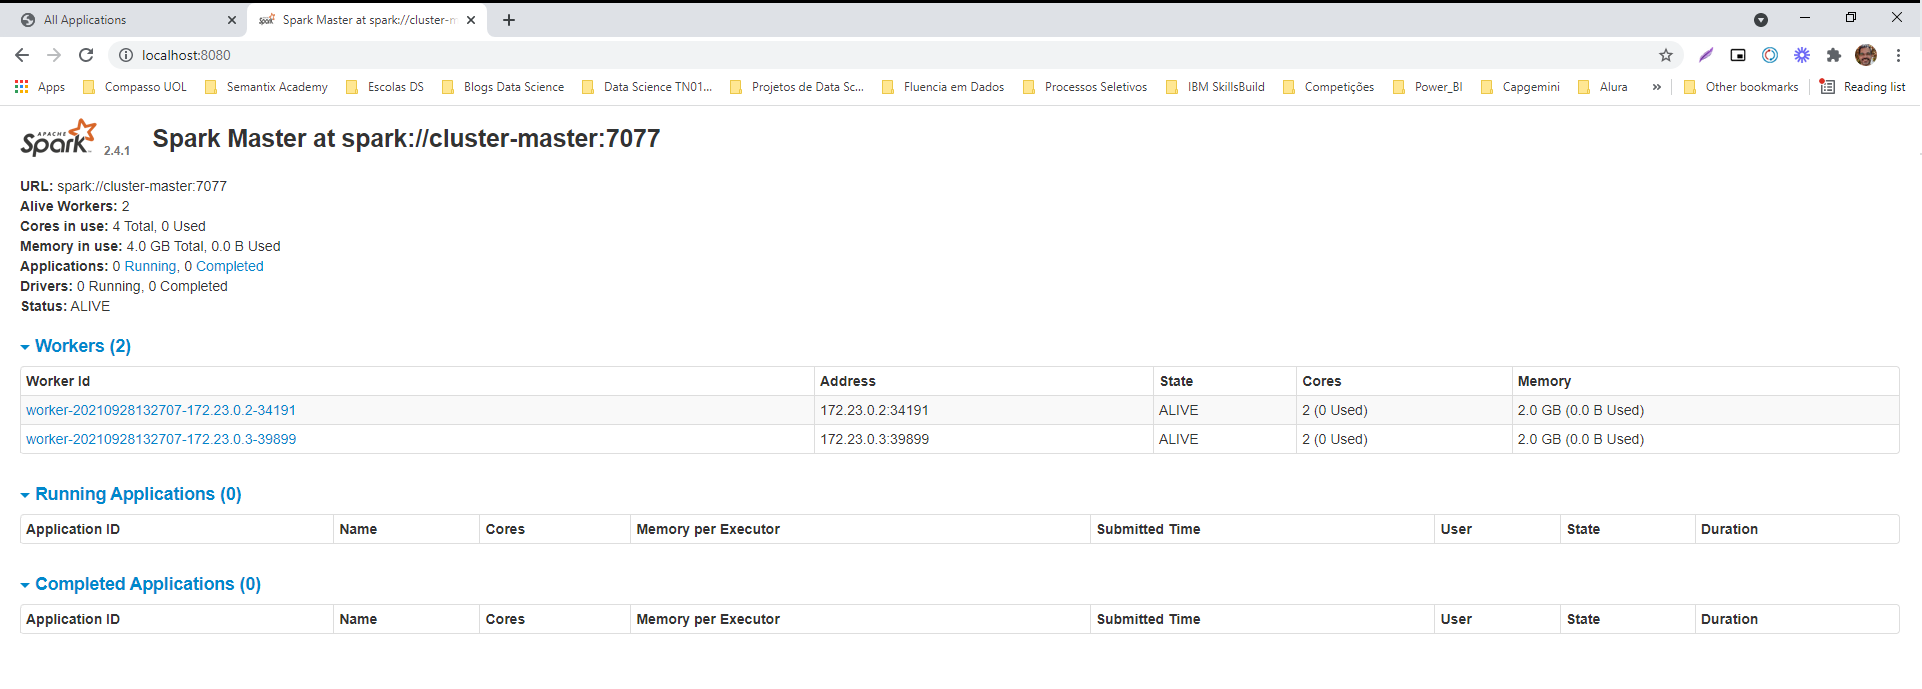

**HDFS Web UI : master-node-ip:50070**

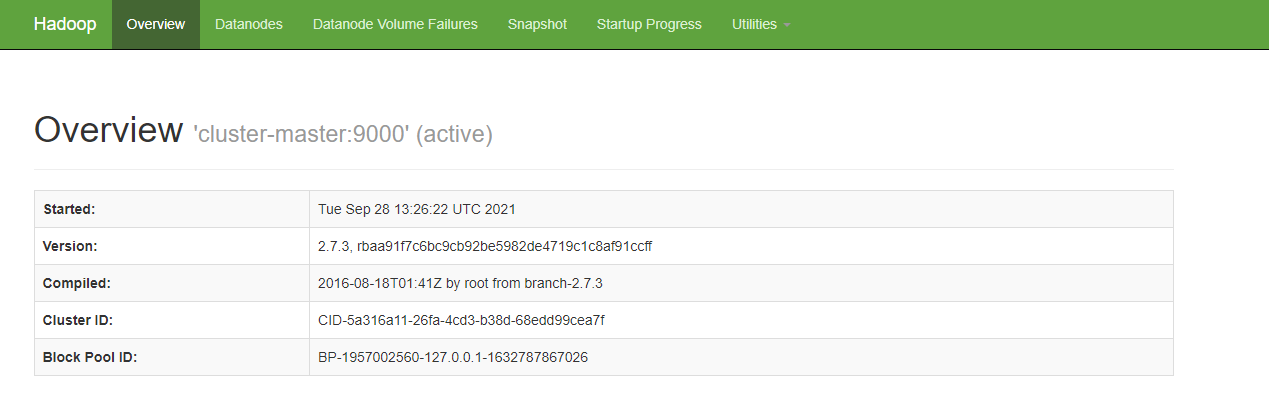

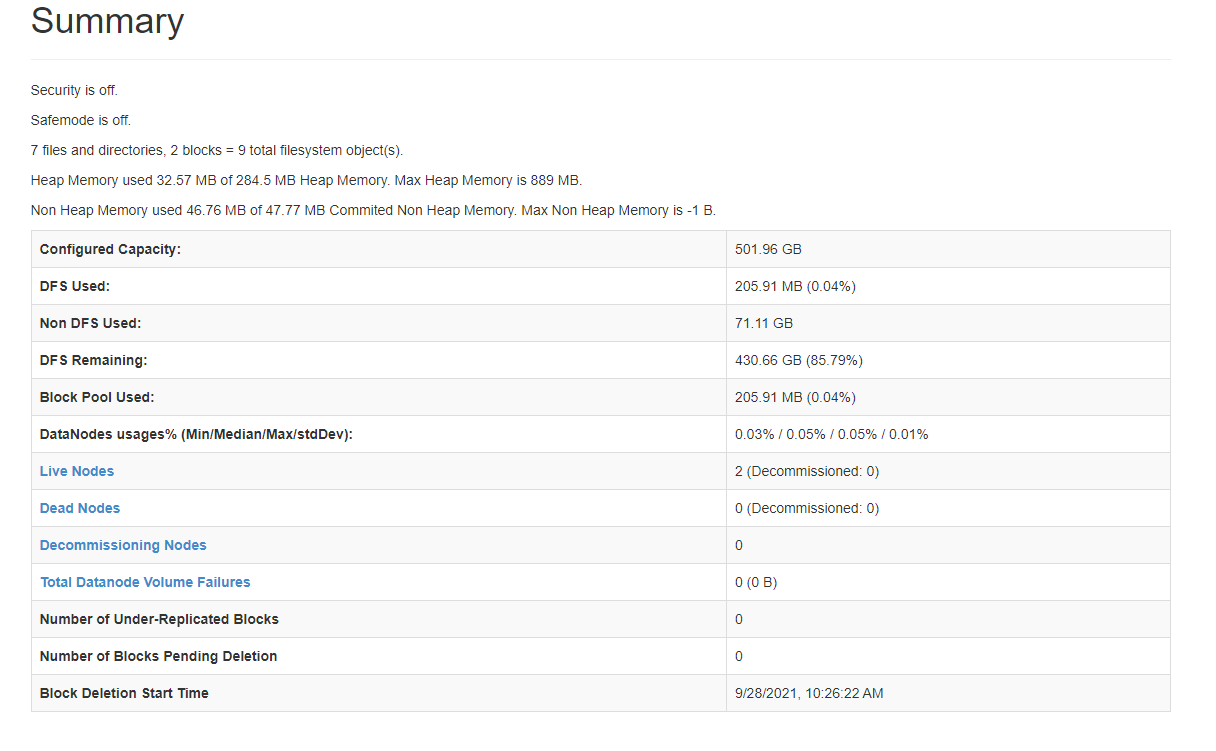

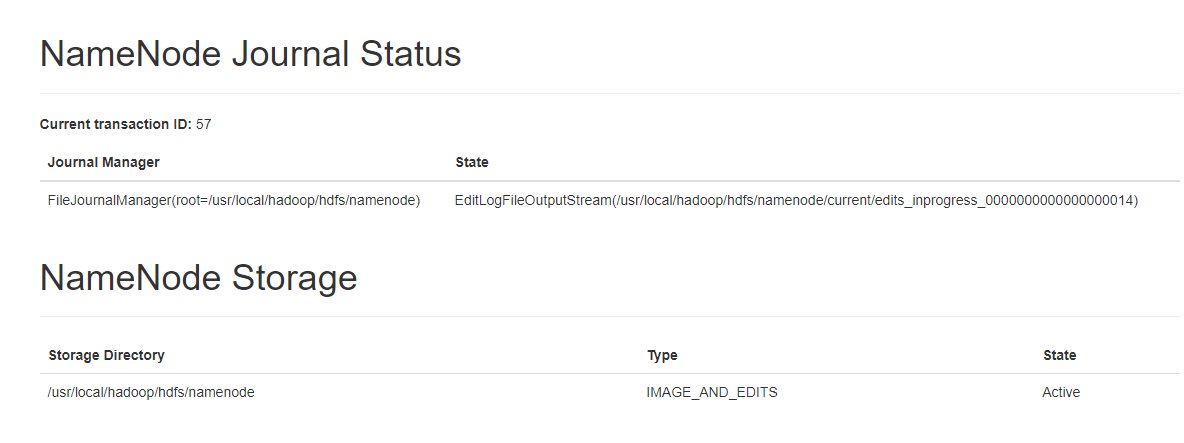

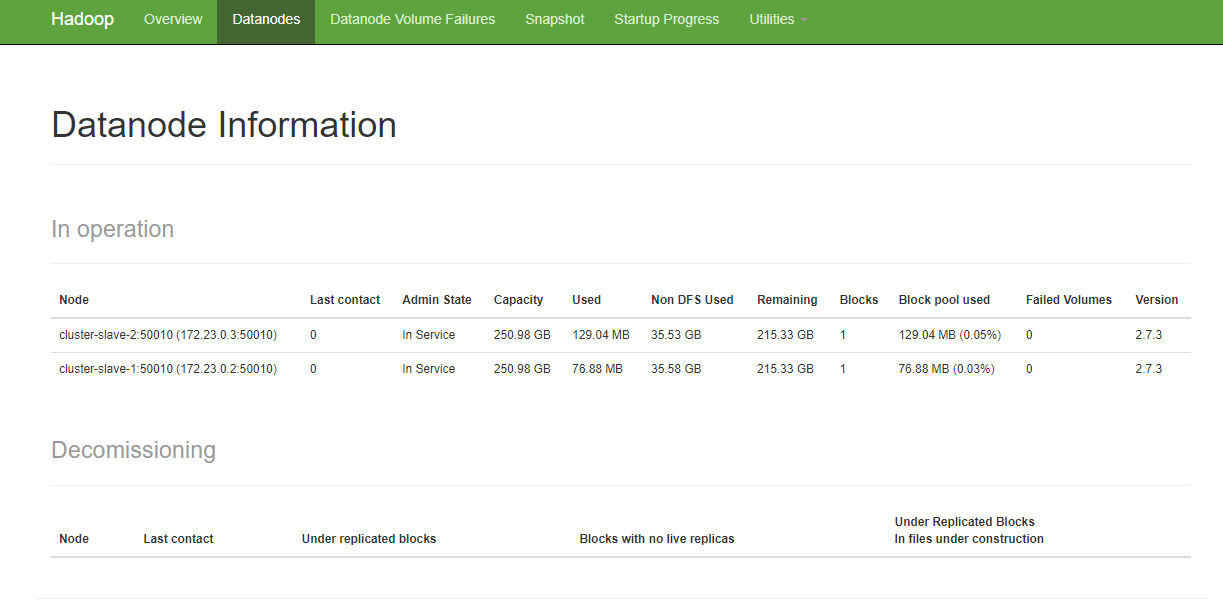

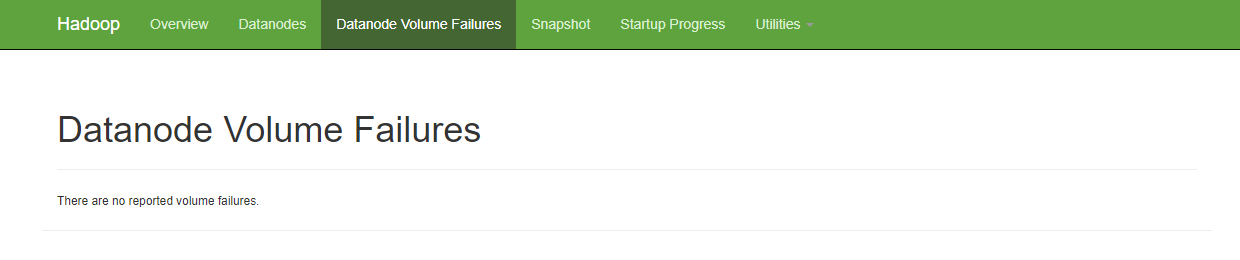

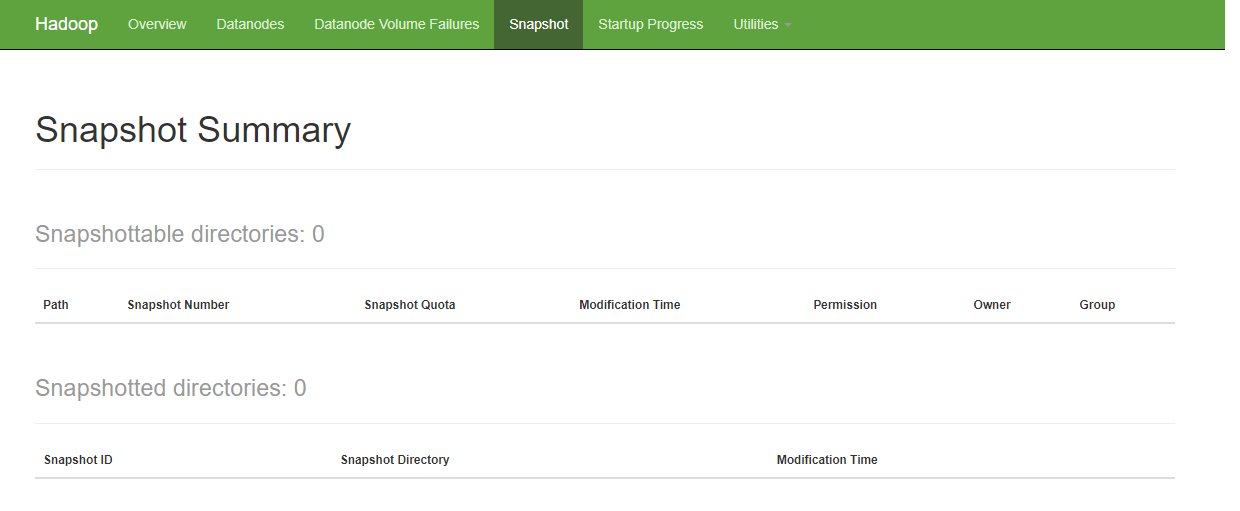

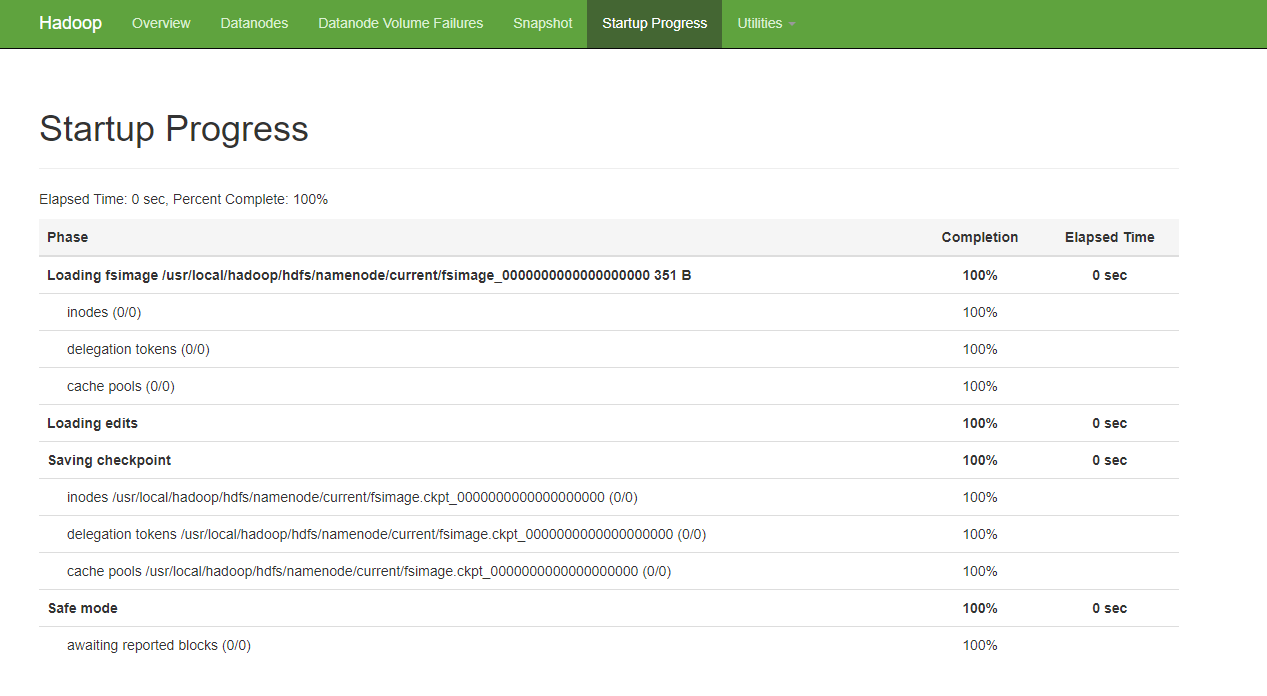

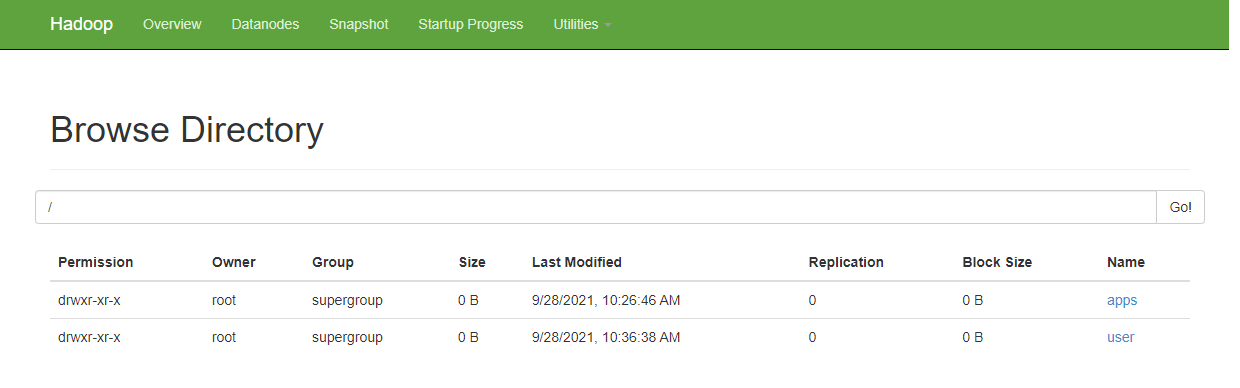

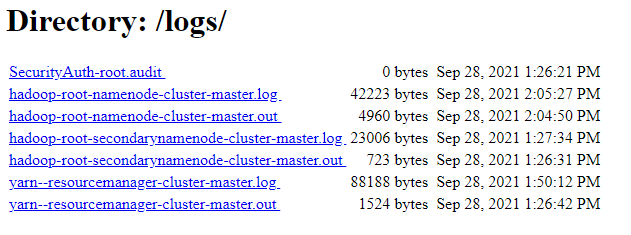

**Cezar Augusto Meira Carmo - cezaraugustomeiracarmo@gmail.com**